In [112]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from hyperopt import tpe, rand, hp, fmin, STATUS_OK, Trials, pyll, space_eval
from hyperopt.pyll.base import scope
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [113]:
sns.set(style='whitegrid', rc={'figure.figsize':[10,8]})
import warnings
warnings.filterwarnings('ignore')

In [114]:
bc = datasets.load_breast_cancer()
X = bc.data
y = bc.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [129]:
bc.feature_names
bc.target_names

array(['malignant', 'benign'], dtype='<U9')

## Grid Search

In [115]:
param_grid = {
    'learning_rate': np.logspace(-5, 0, 5),
    'n_estimators': np.arange(10, 400, 50),
    'min_samples_split': np.arange(2, 8, 1),
    'max_depth': np.arange(1, 8, 1)
}

In [116]:
from sklearn.model_selection import ParameterGrid
n_comb = len(list(ParameterGrid(param_grid)))

In [117]:
gridsearch = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=2, verbose=1, n_jobs=-1)
gridsearch.fit(X_train, y_train)

Fitting 2 folds for each of 1680 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed:  2.4min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  verbose=0, warm_st

In [118]:
y_grid = gridsearch.predict(X_test)
print("Grid Search Accuracy:", accuracy_score(y_test, y_grid))

Grid Search Accuracy: 0.9473684210526315


In [119]:
randsearch = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, n_iter=n_comb/2, cv=2, verbose=1, n_jobs=-1)
randsearch.fit(X_train, y_train)

Fitting 2 folds for each of 840 candidates, totalling 1680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 1680 out of 1680 | elapsed:  1.1min finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [120]:
y_rand = randsearch.predict(X_test)
print("Randomized Grid Search Accuracy:", accuracy_score(y_test, y_rand))

Randomized Grid Search Accuracy: 0.9473684210526315


In [197]:
def obj_func(params):
    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

space = {
    'learning_rate': hp.lognormal('learning_rate', 0, 1),
    'n_estimators': scope.int(hp.quniform('C', 1, 500, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 20, 1)),
    'max_depth': scope.int(hp.qloguniform('max_depth', 0, 4, 1))
}

def f(params):
    acc = obj_func(params)
    return {'loss': -acc, 'status': STATUS_OK}

In [198]:
np.exp(4)

54.598150033144236

(array([55., 13., 12.,  2.,  4.,  2.,  2.,  5.,  2.,  3.]),
 array([ 1. ,  6.2, 11.4, 16.6, 21.8, 27. , 32.2, 37.4, 42.6, 47.8, 53. ]),
 <a list of 10 Patch objects>)

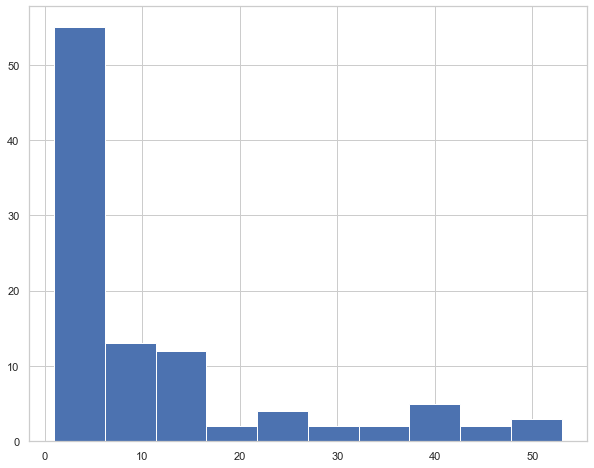

In [199]:
x = [pyll.stochastic.sample(scope.int(hp.qloguniform('max_depth', 0, 4, 1))) for _ in range(100)]
plt.hist(x)

In [200]:
print(pyll.stochastic.sample(space))

{'learning_rate': 0.23784976953726394, 'max_depth': 8, 'min_samples_split': 2, 'n_estimators': 472}


In [201]:
trials = Trials()
best_params = fmin(f, space, algo=tpe.suggest, max_evals=300, trials=trials)

100%|██████████| 300/300 [01:03<00:00,  4.72it/s, best loss: -0.9736842105263158]


In [124]:
space_eval(space, best_params)

{'learning_rate': 1.1919659098269777,
 'max_depth': 1,
 'min_samples_split': 8,
 'n_estimators': 324}

In [125]:
trials.best_trial['result']

{'loss': -0.9736842105263158, 'status': 'ok'}